In [1]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-07-16 14:03:40


In [2]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

import flaml
from flaml import AutoML

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing


from tabpfn import TabPFNClassifier

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
elif os.path.exists('/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'):
    root_dir = '/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'

sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_CERRA.yaml' #sys.argv[1]
train_years = int(17) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    configure = yaml.safe_load(yaml_file)
input_file = configure['input_file']
input_times_freq = configure['input_times_freq']
Coeff_file = configure['Coeff_file']
profiles_file = None if configure['profiles_file'] == '' else configure['profiles_file']
input_variables = configure['input_variables']
train_locations = configure['train_locations']
test_dates_range = configure['test_dates_range']
test_locations = configure['test_locations']
nEns = configure['nEns']
tabnet_param_file = configure['tabnet_param_file']
target_variables = configure['target_variables']
experiment = configure['experiment']

In [3]:
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY",
    "u10","v10","u100","v100","u_950","v_950","u_975","v_975",
    "u10_mean","u10_std","u10_skew","u10_kurt",
    "v10_mean","v10_std","v10_skew","v10_kurt",
    "u100_mean","u100_std","u100_skew","u100_kurt",
    "v100_mean","v100_std","v100_skew","v100_kurt",
    "u_950_mean","u_950_std","u_950_skew","u_950_kurt",
    "v_950_mean","v_950_std","v_950_skew","v_950_kurt",
    "u_975_mean","u_975_std","u_975_skew","u_975_kurt",
    "v_975_mean","v_975_std","v_975_skew","v_975_kurt",
]

In [4]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [6]:
#for run,year in enumerate(np.arange(2000,2017+1-train_years)):
train_dates_range = ['2000-01-01T12','2000-12-31']
print(train_dates_range)

# === training and validation data parameters ===#
X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                    input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                    profiles_file=profiles_file,threshold=2)
print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

['2000-01-01T12', '2000-12-31']
training inputs shape: (6499, 72) training targets shape: (6499, 5) validation inputs shape: (1602, 72) validation targets shape: (1602, 5)


In [9]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01T12')
end_date = pd.Timestamp('2000-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 8748.0


In [12]:
# === testing data parameters ===#
test_dates_range = ['2001-01-01','2001-12-31']
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (8760, 72) testing targets shape: (8760, 5)


In [13]:
from tabpfn import TabPFNRegressor

In [19]:
X_train.shape, Y_train[:,0:1].ravel().shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((6499, 72), (6499,), (1602, 72), (1602, 5), (8760, 72), (8760, 5))

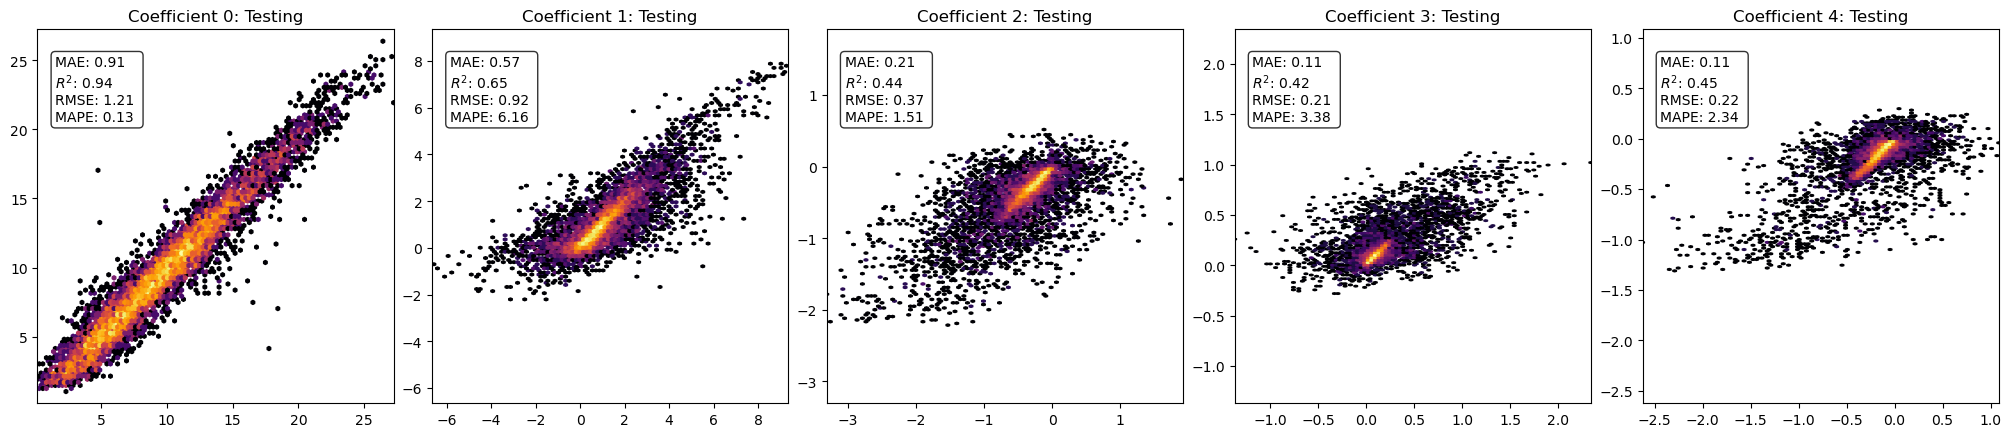

In [24]:
# Initialize the regressor
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)
for i in range(5):
    regressor = TabPFNRegressor()
    regressor.fit(X_train, Y_train[:,i])
    # Predict on the test set
    predictions = regressor.predict(X_test)
    hexbin_plotter(fig,gs[0,i],Y_test[:,i],predictions,f'Coefficient {i}: Testing',text_arg=True)